# Trabalho I

## Parte Teórica

Faça uma descrição de como funcionam generalizações dos classificadores binários para o cenário multiclasse, para os classificadores que vimos até o momento. Mais especificamente, você deverá dizer como que cada um deles pode ser generalizado para problemas multiclasse (é naturalmente embutido em sua teoria? É necessário alguma técnica adicional? O que é OvO? O que é OvA?) Descreva também como que as métricas que vimos são generalizadas para o cenário multiclasse.

## Parte Prática 

## Informação Básica

In [53]:
### Biblioteca

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage.morphology import reconstruction

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

from sklearn import metrics

from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

In [129]:
### Dados

# Treino

feat = pd.read_csv('train_images.csv', header = None)
resp = pd.read_csv('train_labels.csv')

    # Eliminação de 40% das amostras
feat, feat_trash, resp, resp_trash = train_test_split(feat, resp, 
                                                      test_size=0.4, 
                                                      random_state=0, 
                                                      stratify=resp['Volcano?'])

# Teste

feat_test = pd.read_csv('test_images.csv', header = None)
resp_test = pd.read_csv('test_labels.csv')

### Questão 1

Prever, **somente a partir da imagem**, se naquela foto há ou não um vulcão. Ou seja, deve ser resolvido o problema de **classificação binária** onde os dados observados são as linhas do DataFrame ``feat`` e a variável resposta é a coluna ``Volcano?`` do DataFrame ``resp``.

In [ ]:
### Pré-processamento - Treino

hog_feat = []
hogfeat = pd.DataFrame(columns=range(0,110*110))

peak_feat = []
peakfeat = pd.DataFrame(columns=range(0,110*110))


for i in feat:
    image_feat = np.array(feat.iloc[i]).reshape(110,110)
    
    # Peaks
    seed_min = np.copy(image_feat)
    seed_min[1:-1, 1:-1] = image_feat.min()
    
    mask = image_feat
    
    peak_feat = reconstruction(seed_min, mask, method='dilation')
    peakfeat.loc[i,:] = peak_feat.reshape(1,110*110)
    
    # Histogram of Oriented Gradient
    hog_feat.append(hog(peak_feat, visualize=True)[1])
    hogfeat.loc[i,:] = hog_feat[i].reshape(1,110*110)

In [ ]:
### Pré-processamento - Teste

hog_feat_test = []
hogfeat_test = pd.DataFrame(columns=range(0,110*110))

peak_feat_test = []
peakfeat_test = pd.DataFrame(columns=range(0,110*110))


for i in feat:
    image_feat_test = np.array(feat_test.iloc[i]).reshape(110,110)
    
    # Peaks
    seed_min_test = np.copy(image_feat_test)
    seed_min_test[1:-1, 1:-1] = image_feat_test.min()
    
    mask_test = image_feat_test
    
    peak_feat_test = reconstruction(seed_min_test, mask_test, method='dilation')
    peakfeat_test.loc[i,:] = peak_feat_test.reshape(1,110*110)
    
    # Histogram of Oriented Gradient
    hog_feat_test.append(hog(peak_feat_test, visualize=True)[1])
    hogfeat_test.loc[i,:] = hog_feat_test[i].reshape(1,110*110)

In [101]:
hogfeat_test.to_pickle('hogfeat_test.csv')
#hogfeat.to_pickle('hogfeat.csv')

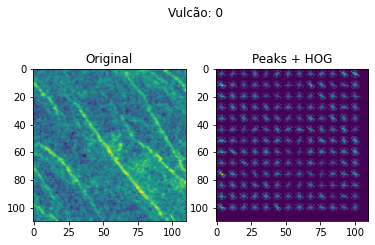

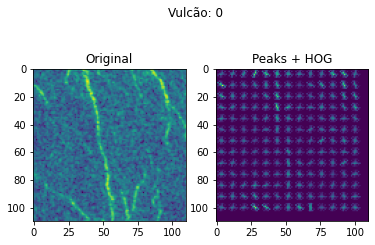

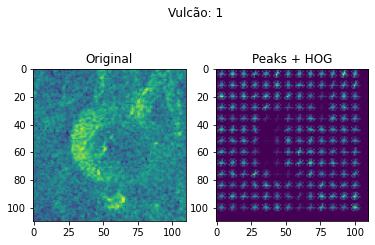

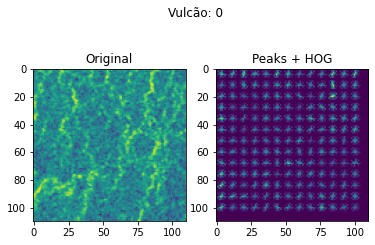

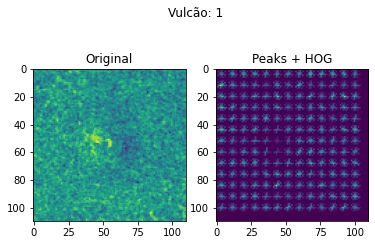

In [48]:
# Plot

for i in range(15, 20):
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.suptitle('Vulcão: ' + str(resp.iloc[i,0]))
    ax1.imshow(np.array(feat.iloc[i]).reshape(110,110))
    ax1.set_title('Original')
    ax2.imshow(hog_feat[i])
    ax2.set_title('Peaks + HOG')

#### Modelos

In [49]:
### Naive Bayes

model_nb = GaussianNB()


### LDA e QDA

model_lda = LinearDiscriminantAnalysis()
model_qda = QuadraticDiscriminantAnalysis()


### SVM

model_svm = SVC()
model_svm_rbf = SVC(kernel='rbf')

In [ ]:
### Cross-Validation - NB, LDA, QDA

scoring = {"AUC": metrics.make_scorer(metrics.roc_auc_score, greater_is_better = True, needs_proba = True), 
           'F1': metrics.make_scorer(metrics.f1_score, greater_is_better = True, needs_proba = False)}

Score_nb = pd.DataFrame(index=['AUC', 'F1'], columns=['Original', 'Peak + HOG'])
for  score in scoring.values():
    cv1_nb = cross_val_score(model_nb, X=feat, y=resp.iloc[:,0], cv = 5,
                scoring = score)
    cv2_nb = cross_val_score(model_nb, X=hogfeat, y=resp.iloc[:,0], cv = 5,
                scoring = score)
    Score_nb.iloc[i,:] = [cv1_nb.mean(), cv2_nb.mean()]
print('NB: ok')

Score_lda = pd.DataFrame(index=['AUC', 'F1'], columns=['Original', 'Peak + HOG'])
for  score in scoring.values():
    cv1_lda = cross_val_score(model_lda, X=feat, y=resp.iloc[:,0], cv = 5,
                scoring = score)
    cv2_lda = cross_val_score(model_lda, X=hogfeat, y=resp.iloc[:,0], cv = 5,
                scoring = score)
    Score_lda.iloc[i,:] = [cv1_lda.mean(), cv2_lda.mean()]
print('LDA: ok')

Score_qda = pd.DataFrame(index=['AUC', 'F1'], columns=['Original', 'Peak + HOG'])
for  score in scoring.values():
    cv1_qda = cross_val_score(model_qda, X=feat, y=resp.iloc[:,0], cv = 5,
                scoring = score)
    cv2_qda = cross_val_score(model_qda, X=hogfeat, y=resp.iloc[:,0], cv = 5,
                scoring = score)
    Score_qda.iloc[i,:] = [cv1_qda.mean(), cv2_qda.mean()]
print('QDA: ok') 

In [51]:
print('NB', Score_nb)
print('LDA', Score_lda)
print('QDA', Score_qda)

NB      Original Peak + HOG
AUC  0.546039   0.616924
F1   0.264875   0.300839
LDA      Original Peak + HOG
AUC  0.888613    0.76262
F1   0.647382   0.441546
QDA      Original Peak + HOG
AUC   0.66875        0.5
F1   0.334757        0.0


In [ ]:
### Cross Validation - SVM

param_svm = [{'kernel': ['linear', 'poly'],
              'C': [10, 100, 1000]}]
param_svm_rbf = [{'C': [10, 100, 1000],
                  'gamma': [10, 100, 1000]}]

cv1_svm = GridSearchCV(model_svm, param_grid = param_svm, cv = 5, 
                          scoring = 'f1', verbose = 4, n_jobs = -1)
fit1_svm_01 = cv1_svm.fit(feat, resp.iloc[:,0])
fit1_svm_02 = cv1_svm.fit(hogfeat, resp.iloc[:,0])
print('SVM 1: ok')

cv2_svm = GridSearchCV(model_svm, param_grid = param_svm, cv = 5, 
                          scoring = 'roc_auc', verbose = 4, n_jobs = -1)
fit2_svm_01 = cv2_svm.fit(feat, resp.iloc[:,0])
fit2_svm_02 = cv2_svm.fit(hogfeat, resp.iloc[:,0])
print('SVM 2: ok')

cv1_svm_rbf = GridSearchCV(model_svm_rbf, param_grid = param_svm_rbf, cv = 5, 
                          scoring = 'f1', verbose = 4, n_jobs = -1)
fit1_svmrbf_01 = cv1_svm_rbf.fit(feat, resp.iloc[:,0])
fit1_svmrbf_02 = cv1_svm_rbf.fit(hogfeat, resp.iloc[:,0])
print('SVM 1 RBF: ok')

cv2_svm_rbf = GridSearchCV(model_svm_rbf, param_grid = param_svm_rbf, cv = 5, 
                          scoring = 'roc_auc', verbose = 4, n_jobs = -1)
fit2_svmrbf_01 = cv2_svm_rbf.fit(feat, resp.iloc[:,0])
fit2_svmrbf_02 = cv2_svm_rbf.fit(hogfeat, resp.iloc[:,0])
print('SVM 2 RBF: ok')

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [ ]:
### Resultados


F1_nb = {
    'Naive Bayes' : metrics.f1_score(resp_test.iloc[:,0], model_nb.predict(feat_test))
}

F1_da = {
    'LDA': metrics.f1_score(resp_test.iloc[:,0], model_lda.predict(feat_test)),
    'QDA': metrics.f1_score(resp_test.iloc[:,0], model_qda.predict(feat_test))
        }

F1_svm = {
    'Linear': metrics.f1_score(resp_test.iloc[:,0], model_svm_lin.predict(feat_test)),
    'Polynomial': metrics.f1_score(resp_test.iloc[:,0], model_svm_pol.predict(feat_test)),
    'RBF': metrics.f1_score(resp_test.iloc[:,0], model_svm_rbf.predict(feat_test))
}


F1 = pd.DataFrame(
    {
        'Modelo' : ['Naive Bayes', 'LDA', 'QDA', 'SVM - Liner', 'SVM - Polinomial', 'SVM - RBF'],
        'F1 Score': [F1_nb['Naive Bayes'], F1_da['LDA'], F1_da['QDA'], 
                     F1_svm['Linear'], F1_svm['Polynomial'], F1_svm['RBF']]
    }
)
    
print(F1)

In [121]:

param_svm = [{'kernel': ['linear', 'poly'],
              'C': [10, 100, 1000]}]
param_svm_rbf = [{'C': [10, 100, 1000],
                  'gamma': [10, 100, 1000]}]
cv1_svm = GridSearchCV(model_svm, param_grid = param_svm, cv = 5, 
                          scoring = 'f1', verbose = 4, n_jobs = -1)
cv1_svm.fit(hogfeat.iloc[0:20,:], resp.iloc[0:20,0])

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [10, 100, 1000], 'kernel': ['linear', 'poly']}],
             scoring='f1', verbose=4)

****

### Questão 2

Prever, **somente a partir das imagens que têm ao menos um vulcão**, o "tipo" dele. Ou seja, deve ser resolvido o problema de **classificação multiclasse** onde os dados observados são as linhas do DataFrame ``feat`` para as quais a variável ``Volcano?`` é 1, e a variável resposta é a coluna ``Type`` do DataFrame ``resp``.

In [113]:
### Variavel multiclasse

multi_index = resp[resp['Volcano?']==1].index.to_numpy()

multi_feat = feat.loc[multi_index]
multi_resp = resp.loc[multi_index]

#### Modelos

In [102]:
### Naive Bayes

ovo_nb = OneVsOneClassifier(GaussianNB(), n_jobs = -1)
ovr_nb = OneVsRestClassifier(GaussianNB(), n_jobs = -1)

### SVM

ovo_svm = OneVsOneClassifier(SVC(), n_jobs = -1)
ovr_svm = OneVsRestClassifier(SVC(), n_jobs = -1)

ovo_svm_rbf = OneVsOneClassifier(SVC(kernel='rbf'), n_jobs = -1)
ovr_svm_rbf = OneVsRestClassifier(SVC(kernel='rbf'), n_jobs = -1)

In [ ]:
### Cross-Validation - NB, LDA, QDA

scoring = {"AUC": metrics.make_scorer(metrics.roc_auc_score, greater_is_better = True, needs_proba = True), 
           'F1': metrics.make_scorer(metrics.f1_score, greater_is_better = True, needs_proba = False)}

Score_nb = pd.DataFrame(index=['AUC', 'F1'], columns=['Original', 'Peak + HOG'])
for  score in scoring.values():
    cv1_nb = cross_val_score(model_nb, X=feat, y=resp.iloc[:,0], cv = 5,
                scoring = score)
    cv2_nb = cross_val_score(model_nb, X=hogfeat, y=resp.iloc[:,0], cv = 5,
                scoring = score)
    Score_nb.iloc[i,:] = [cv1_nb.mean(), cv2_nb.mean()]
print('NB: ok')

Score_lda = pd.DataFrame(index=['AUC', 'F1'], columns=['Original', 'Peak + HOG'])
for  score in scoring.values():
    cv1_lda = cross_val_score(model_lda, X=feat, y=resp.iloc[:,0], cv = 5,
                scoring = score)
    cv2_lda = cross_val_score(model_lda, X=hogfeat, y=resp.iloc[:,0], cv = 5,
                scoring = score)
    Score_lda.iloc[i,:] = [cv1_lda.mean(), cv2_lda.mean()]
print('LDA: ok')

Score_qda = pd.DataFrame(index=['AUC', 'F1'], columns=['Original', 'Peak + HOG'])
for  score in scoring.values():
    cv1_qda = cross_val_score(model_qda, X=feat, y=resp.iloc[:,0], cv = 5,
                scoring = score)
    cv2_qda = cross_val_score(model_qda, X=hogfeat, y=resp.iloc[:,0], cv = 5,
                scoring = score)
    Score_qda.iloc[i,:] = [cv1_qda.mean(), cv2_qda.mean()]
print('QDA: ok') 


In [ ]:
### Cross-Validation - SVM

param_svm = [{'kernel': ['linear', 'poly'],
              'C': [10, 100, 1000]}]
param_svm_rbf = [{'C': [10, 100, 1000],
                  'gamma': [10, 100, 1000]}]

    # OVR
cv1ovr_svm = GridSearchCV(ovr_svm, param_grid = param_svm, cv = 5, 
                          scoring = 'f1', verbose = 4, n_jobs = -1)
fit1ovr_svm_01 = cv1ovr_svm.fit(feat, resp.iloc[:,0])
fit1ovr_svm_02 = cv1ovr_svm.fit(hogfeat, resp.iloc[:,0])
print('SVM 1: ok')

cv2ovr_svm = GridSearchCV(ovr_svm, param_grid = param_svm, cv = 5, 
                          scoring = 'roc_auc', verbose = 4, n_jobs = -1)
fit2ovr_svm_01 = cv2ovr_svm.fit(feat, resp.iloc[:,0])
fit2ovr_svm_02 = cv2ovr_svm.fit(hogfeat, resp.iloc[:,0])

    # OVR
cv1ovr_svm_rbf = GridSearchCV(model_svm_rbf, param_grid = param_svm_rbf, cv = 5, 
                          scoring = 'f1', verbose = 4, n_jobs = -1)
fit1ovr_svmrbf_01 = cv1ovr_svm_rbf.fit(feat, resp.iloc[:,0])
fit1ovr_svmrbf_02 = cv1ovr_svm_rbf.fit(hogfeat, resp.iloc[:,0])
print('SVM 1 RBF: ok')

cv2ovr_svm_rbf = GridSearchCV(ovr_svm_rbf, param_grid = param_svm_rbf, cv = 5, 
                          scoring = 'roc_auc', verbose = 4, n_jobs = -1)
fit2ovr_svmrbf_01 = cv2ovr_svm_rbf.fit(feat, resp.iloc[:,0])
fit2ovr_svmrbf_02 = cv2ovr_svm_rbf.fit(hogfeat, resp.iloc[:,0])
print('SVM 2 RBF: ok')

****